In [1]:
import tensorflow as tf

tf.enable_eager_execution()
tf.executing_eagerly()

True

In [300]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Conv2D, Input, MaxPooling2D, BatchNormalization, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
import numpy as np
from utils import read_labels, draw_image, image_to_yolo_input, Object, parse_annotation, Annotation, calculate_IoU, image_to_vgg_input
from PIL import Image as Img
import os
import matplotlib.pyplot as plt

In [377]:
#TODO: read from config

image_width = 416
image_height = 416
grid_width = int(image_width / 32) # 13
grid_height = int(image_height / 32) # 13

cell_width = image_width / grid_width
cell_height = image_height / grid_height

boxes = 5

activation_alpha = 0.1

object_scale = 200
noobject_scale = 1
class_scale = 1
coord_scale = 1

threshhold = 0.6

anchors = [[1.05, 1.65], [2.44, 4.13], [4.01, 8.46], [7.62, 5.13], [9.97, 10.43]] # obtained from KMeans experiments ipynb

batch_size = 50

labels_dir = "./labels.txt"

annotation_folder = '.\VOCdevkit\VOC2007\Annotations'
images_folder = '.\VOCdevkit\VOC2007\JPEGImages'

test_annotation = r'.\VOCdevkit\VOC2007\Annotations\000019.xml'
test_image = r'.\VOCdevkit\VOC2007\JPEGImages\000019.jpg'

In [4]:
labels, labels_count = read_labels(labels_dir)


labels_count = 0 # TODO: remove when implementing classification

print(labels_count)
print(labels)

0
['horse', 'diningtable', 'sofa', 'train', 'bird', 'aeroplane', 'person', 'boat', 'bottle', 'motorbike', 'bus', 'cat', 'pottedplant', 'car', 'dog', 'bicycle', 'sheep', 'cow', 'tvmonitor', 'chair']


In [5]:
layers = []

layers.append(Input(shape=(image_width, image_height, 3)))

layers.append(Conv2D(filters = 16, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_1"))
layers.append(BatchNormalization(name = "norm_1"))
layers.append(LeakyReLU(name = "leaky_1", alpha = activation_alpha))
layers.append(MaxPooling2D(name = "maxpool_1"))

layers.append(Conv2D(filters = 32, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_2"))
layers.append(BatchNormalization(name = "norm_2"))
layers.append(LeakyReLU(name = "leaky_2", alpha = activation_alpha))
layers.append(MaxPooling2D(name = "maxpool_2"))

layers.append(Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_3"))
layers.append(BatchNormalization(name = "norm_3"))
layers.append(LeakyReLU(name = "leaky_3", alpha = activation_alpha))
layers.append(MaxPooling2D(name = "maxpool_3"))

layers.append(Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_4"))
layers.append(BatchNormalization(name = "norm_4"))
layers.append(LeakyReLU(name = "leaky_4", alpha = activation_alpha))
layers.append(MaxPooling2D(name = "maxpool_4"))

layers.append(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_5"))
layers.append(BatchNormalization(name = "norm_5"))
layers.append(LeakyReLU(name = "leaky_5", alpha = activation_alpha))
layers.append(MaxPooling2D(name = "maxpool_5"))

layers.append(Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_6"))
layers.append(BatchNormalization(name = "norm_6"))
layers.append(LeakyReLU(name = "leaky_6", alpha = activation_alpha))
#layers.append(MaxPooling2D(name = "maxpool_6", pool_size = (2, 2), strides = (1, 1)))

layers.append(Conv2D(filters = 1024, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_7"))
layers.append(BatchNormalization(name = "norm_7"))
layers.append(LeakyReLU(name = "leaky_7", alpha = activation_alpha))

layers.append(Conv2D(filters = 1024, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_8"))
layers.append(BatchNormalization(name = "norm_8"))
layers.append(LeakyReLU(name = "leaky_8", alpha = activation_alpha))

layers.append(Conv2D(filters = (boxes * (4 + 1 + labels_count)), kernel_size = (1, 1), padding = "same", name="conv_9"))

layers.append(Reshape(target_shape = (grid_width, grid_height, boxes, 5 + labels_count), name = "output"))

tinyyolov2 = Sequential(layers = layers, name = "tiny yolov2 voc")
tinyyolov2.summary()

Model: "tiny yolov2 voc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 416, 416, 16)      432       
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 416, 416, 16)      64        
_________________________________________________________________
leaky_1 (LeakyReLU)          (None, 416, 416, 16)      0         
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 208, 208, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 208, 208, 32)      4608      
_________________________________________________________________
norm_2 (BatchNormalization)  (None, 208, 208, 32)      128       
_________________________________________________________________
leaky_2 (LeakyReLU)          (None, 208, 208, 32)  

row 7 col 8
anchor_w: 1.05, cell_width: 38.46153846153846, width: 40.38461538461539
anchor_h: 1.65, cell_height: 25.53846153846154, height: 42.13846153846154
unnamed (0) (306.7307692307692, 170.46923076923076) (347.1153846153846, 212.60769230769233)
IoU: 0.1430503717190108
True
----- 13


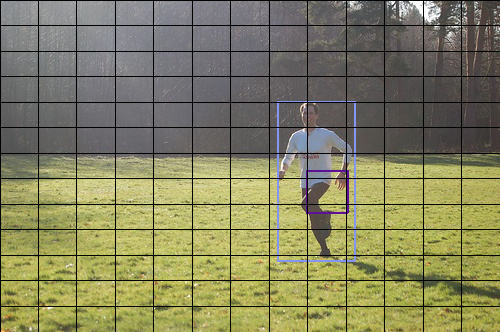

anchor_w: 2.44, cell_width: 38.46153846153846, width: 93.84615384615384
anchor_h: 4.13, cell_height: 25.53846153846154, height: 105.47384615384615
unnamed (0) (280.0, 138.80153846153848) (373.8461538461538, 244.2753846153846)
IoU: 0.5472134412199644
True
----- 13


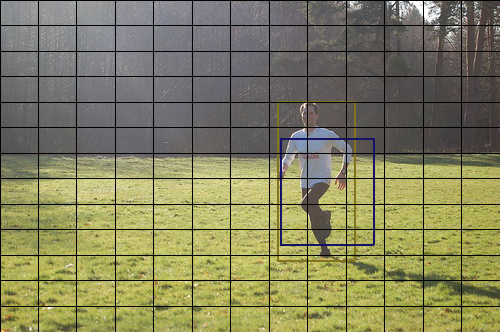

anchor_w: 4.01, cell_width: 38.46153846153846, width: 154.23076923076923
anchor_h: 8.46, cell_height: 25.53846153846154, height: 216.05538461538464
unnamed (0) (249.8076923076923, 83.51076923076923) (404.03846153846155, 299.56615384615384)
IoU: 0.3703959349060193
True
----- 13


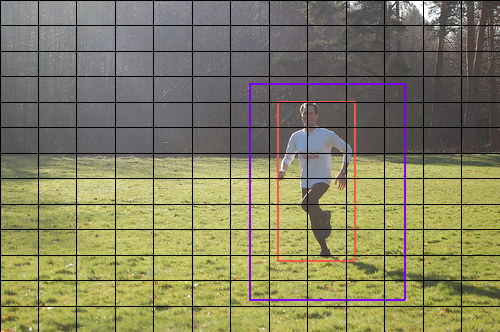

anchor_w: 7.62, cell_width: 38.46153846153846, width: 293.0769230769231
anchor_h: 5.13, cell_height: 25.53846153846154, height: 131.0123076923077
unnamed (0) (180.38461538461536, 126.0323076923077) (473.46153846153845, 257.0446153846154)
IoU: 0.2511158857402083
True
----- 13


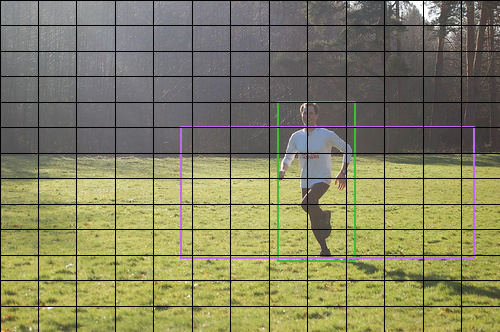

anchor_w: 9.97, cell_width: 38.46153846153846, width: 383.46153846153845
anchor_h: 10.43, cell_height: 25.53846153846154, height: 266.36615384615385
unnamed (0) (135.19230769230768, 58.35538461538462) (518.6538461538462, 324.72153846153844)
IoU: 0.12141022312209347
True
----- 13


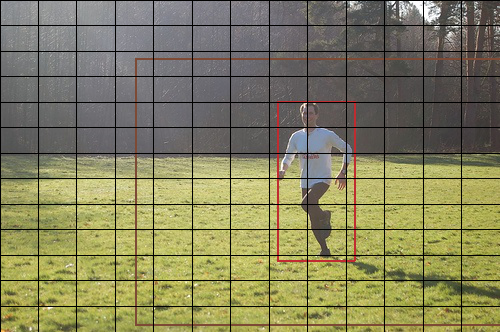

In [435]:
def get_annotations_images(annotations_dir, images_dir):
    image_formats = ['.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif']
    
    annons, images = [], []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(annotations_dir):
        for file in f:
            if '.xml' in file:
                image_exists = False
                for im_format in image_formats:
                    image_name = file[:-4] + im_format
                   
                    image_path = images_dir + '\\' + image_name
                    
                    if os.path.exists(image_path):
                        image_exists = True
                        break
                        
                if image_exists:
                    annons.append(annotations_dir + '\\' + file)
                    images.append(images_dir + '\\' + image_name)

    annons = annons[:500]
    images = images[:500]
    
    return annons, images

def inverse_sigmoid(x):
    return np.log(x / (1 - x))

def encode_y_true_from_annotatoin(annotation):    
    y_true = np.zeros(shape = (grid_width, grid_height, boxes, 5 + labels_count))
    objs = [[[] for col in range(grid_width)] for row in range(grid_height)]
    
    annotation = parse_annotation(annotation)
    
    image_cell_width = annotation.imagewidth / grid_width
    image_cell_height = annotation.imageheight / grid_height
    
    for obj in annotation.objects:
        obj.xmid = (obj.xmax + obj.xmin) / 2
        obj.ymid = (obj.ymax + obj.ymin) / 2
        obj.width = obj.xmax - obj.xmin
        obj.height = obj.ymax - obj.ymin

        row = int(obj.ymid / image_cell_height)
        col = int(obj.xmid / image_cell_width)
        print(f'row {row} col {col}')
        
        objs[row][col].append(obj)        
    
        best_anchor_index = 0
        best_IoU = -1
        
        for index in range(boxes):
            anchor_w, anchor_h = anchors[index]
            print(f'anchor_w: {anchor_w}, cell_width: {image_cell_width}, width: {anchor_w * image_cell_width}')
            print(f'anchor_h: {anchor_h}, cell_height: {image_cell_height}, height: {anchor_h * image_cell_height}')
            
            width = anchor_w * image_cell_width
            height = anchor_h * image_cell_height
            
            xmid = (col + 0.5) * image_cell_width
            ymid = (row + 0.5) * image_cell_height
            
            anchor_object = Object(xmin = xmid - width/2, xmax = xmid + width/2, ymin = ymid - height/2, ymax = ymid + height/2)
            print(anchor_object)
            
            current_IoU = calculate_IoU(obj, anchor_object)
            print(f'IoU: {current_IoU}')
            draw_image(images_folder + '\\'  + annotation.filename[:-4] + '.jpg', objects = [obj, anchor_object], draw_grid = True, grid_size = (grid_width, grid_height))
            if current_IoU > best_IoU:
                best_IoU = current_IoU
                best_anchor_index = index
                   
        '''
        sx = obj.xmid / cell_width - col
        sy = obj.ymid / cell_height - row

        # so that i don't get divison over 0 in inverse sigmoid
        if sx == 1.0:
            sx += 0.000001
        if sy == 1.0:
            sy += 0.000001

        x = inverse_sigmoid(sx)
        y = inverse_sigmoid(sy)

        w = np.log(obj.width / anchor_w)
        h = np.log(obj.height / anchor_h)            
        c = best_IoU


        y_true[row][col][best_anchor_index] = [c, x, y, w, h]
        if np.any(np.isnan(y_true[row][col][[best_anchor_index]])):
            print("BIG REEEEEEEE")
            print(sx)
            print(obj.xmid - (col * cell_width))
            print(inverse_sigmoid(sx))
            return y_true
        '''   
        x = obj.xmid
        y = obj.ymid
        
        w = obj.width
        h = obj.height
        
        c = 1#best_IoU
        
        y_true[row][col][best_anchor_index] = [c, x, y, w, h]
    
    
    return y_true

# TODO: make it work with any batch size
def custom_loss(y_true, y_pred):    
    c_pred = y_pred[:, :, :, :, 0]
    c_true = y_true[:, :, :, :, 0]

    cell_x = np.reshape(np.tile(range(grid_width), [grid_height]), (1, grid_height, grid_width, 1, 1))
    
    xpred = tf.sigmoid(y_pred[:, :, :, :, 1]) + cell_x
    ypred = y_pred[:, :, :, :, 2]                
    xtrue = y_true[:, :, :, :, 1]
    ytrue = y_true[:, :, :, :, 2]

    wpred = y_pred[:, :, :, :, 3]
    hpred = y_pred[:, :, :, :, 4]                
    wtrue = y_true[:, :, :, :, 3]
    htrue = y_true[:, :, :, :, 4]

    xy_pred = y_pred[:, :, :, :, 1 : 3]
    xy_true = y_true[:, :, :, :, 1 : 3]

    wh_pred = y_pred[:, :, :, :, 3 : 5]
    wh_true = y_true[:, :, :, :, 3 : 5]

    intermins = tf.maximum(xy_true, xy_pred)
    intermaxes = tf.minimum(xy_true, xy_pred)

    interArea = tf.maximum(0.0, intermaxes[..., 0] - intermins[..., 0] + 1) * tf.maximum(0.0, intermaxes[..., 1] - intermins[..., 1] + 1)

    groundTruthArea = (wh_true[..., 0] + 1) * (wh_true[..., 1] + 1)
    predictedArea = (wh_pred[..., 0] + 1) * (wh_pred[..., 1] + 1)

    iou = interArea / (groundTruthArea + predictedArea - interArea)

    
    mask_shape = (batch_size, grid_width, grid_height, boxes)
    
    objs = tf.ones(shape = (mask_shape)) * object_scale
    noobjs = tf.ones(shape = (mask_shape)) * noobject_scale
    coords = tf.ones(shape = (mask_shape)) * coord_scale
    noobjscoords = tf.zeros(shape = (mask_shape))

    greaters = tf.greater(iou, 0.0) # c_true?
    confcoef = tf.where(greaters, objs, noobjs)                
    xywhcoef = tf.where(greaters, coords, noobjscoords)
    
    print(c_true)
    print(iou)
    confloss = confcoef * ((c_true - iou) ** 2)
    #print((c_true - iou) ** 2)
    #print(confloss)
    xyloss = xywhcoef * ((xtrue - xpred) ** 2) + xywhcoef * ((ytrue - ypred) ** 2)
    whloss = xywhcoef * ((wtrue - wpred) ** 2) + xywhcoef * ((htrue - hpred) ** 2)                         
    
    loss = confloss #+ whloss + xyloss
    
    loss = tf.reduce_mean(loss)
    #print(np.any(np.isnan(xywhcoef)))
    #print(np.any(np.isnan(((xtrue - xpred) ** 2))))
    #print(np.any(np.isnan(xywhcoef * ((xtrue - xpred) ** 2))))
    #print(loss)
    
    return loss

def custom_loss(y_true, y_pred):
    c_pred = tf.sigmoid(y_pred[:, :, :, :, 0])
    c_true = y_true[:, :, :, :, 0]
    
    greaters = tf.greater(c_true, 0.0)
    
    mask_shape = (batch_size, grid_width, grid_height, boxes)
    objs = tf.ones(shape = (mask_shape)) * object_scale
    noobjs = tf.ones(shape = (mask_shape)) * noobject_scale
    
    coef = tf.where(greaters, objs, noobjs) 
    
    
    
    return coef * (c_true - c_pred) ** 2

runningman = images[52]
runningmanannot = annotations[52]
encoded = encode_y_true_from_annotatoin(runningmanannot)

500
row: 3 col: 6 box: 0
row: 3 col: 7 box: 0
row: 3 col: 8 box: 0
row: 3 col: 9 box: 0
row: 4 col: 6 box: 0
row: 4 col: 7 box: 0
row: 4 col: 8 box: 0
row: 4 col: 9 box: 0
row: 5 col: 6 box: 0
row: 5 col: 7 box: 0
row: 5 col: 8 box: 0
row: 5 col: 9 box: 0
row: 6 col: 6 box: 0
row: 6 col: 7 box: 0
row: 6 col: 8 box: 0
row: 6 col: 9 box: 0
row: 7 col: 6 box: 0
row: 7 col: 7 box: 0
row: 7 col: 8 box: 0
row: 7 col: 9 box: 0
row: 8 col: 7 box: 0
row: 8 col: 8 box: 0
row: 8 col: 9 box: 0
row: 9 col: 7 box: 0
row: 9 col: 8 box: 0
row: 9 col: 9 box: 0
unnamed (0.8418962992015863) (229.8076923076923, 68.31538461538462) (270.1923076923077, 110.45384615384617)
unnamed (0.9424905189340085) (268.2692307692307, 68.31538461538462) (308.65384615384613, 110.45384615384617)
unnamed (0.7831459928340053) (306.7307692307692, 68.31538461538462) (347.11538461538464, 110.45384615384617)
unnamed (0.7351085528671614) (345.1923076923077, 68.31538461538462) (385.5769230769231, 110.45384615384617)
unnamed (0.99577

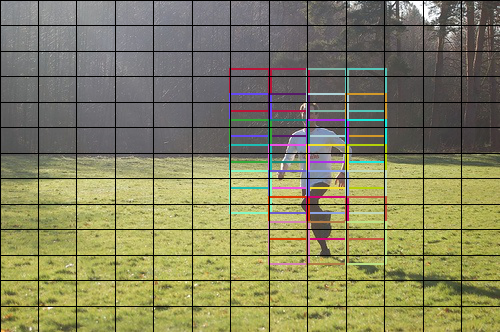

In [436]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def decode_prediction(y_pred, onlyconf = False):
    objects = []
    
    for row in range(grid_height):
        for col in range(grid_width):
            for box in range(boxes):
                to, tx, ty, tw, th = y_pred[row, col, box]
                
                conf = sigmoid(to)           
                               
                #if conf >= threshhold and row == 3 and col == 3:
                if conf >= threshhold:
                    print(f'row: {row} col: {col} box: {box}')
                    if onlyconf:
                        bx = (col + 0.5) * cell_width
                        by = (row + 0.5) * cell_height

                        pw, ph = anchors[box]

                        bw = pw * cell_width
                        bh = ph * cell_height

                        #bw *= cell_width
                        #bh *= cell_height
                    else:
                        bx = (sigmoid(tx) + col) * grid_width
                        by = (sigmoid(ty) + row) * grid_width

                        pw, ph = anchors[box]

                        bw = pw * np.exp(tw)
                        bh = ph * np.exp(tw)

                        bw *= cell_width
                        bh *= cell_height
                    
                    objects.append(Object(xmin = bx - bw/2, xmax = bx + bw/2, ymin = by - bh/2, ymax = by + bh/2, conf = conf))
    return objects

def feed_forward(model, image_path):
    im = Img.open(image_path)
    
    width_scale = im.width / image_width
    height_scale = im.height / image_height 
    print(im.width)
    
    im = im.resize((image_width, image_height))
    im = np.array(im, np.float32)
    im /= 255
    
    y_pred = model.predict(np.array([im]))[0]
    
    objects = decode_prediction(y_pred, True)
    
    for obj in objects:
              
        
        w = obj.xmax - obj.xmin
        h = obj.ymax - obj.ymin
        #w *= grid_width
        #h *= grid_height
        
        xmid = (obj.xmax - obj.xmin) / 2
        ymid = (obj.ymax - obj.ymin) / 2
        
        #obj.xmin = xmid - w/2
        #obj.xmax = xmid + w/2
        #obj.ymin = ymid - h/2
        #obj.ymax = ymid + h/2
        
        
        
        obj.xmin *= width_scale
        obj.xmax *= width_scale
        obj.ymin *= height_scale
        obj.ymax *= height_scale
        
        
        
        #obj.xmin = obj.xmin * image_cell_width
        #obj.xmax = obj.xmax * image_cell_width
        #obj.ymin = obj.ymin * image_cell_height
        #obj.ymax = obj.ymax * image_cell_height
        print(obj)
    
    draw_image(image_path, objects, draw_grid = True, grid_size = (grid_width, grid_height))
    
    

feed_forward(mobilenetyolov2, runningman)
#feed_forward(tinyyolov2, test_image)

In [204]:
annotations, images = get_annotations_images(annotation_folder, images_folder)
ins = np.array([image_to_vgg_input(image, inputshape = (image_width, image_height)) for image in images], dtype=np.float32)
outs = np.array([encode_y_true_from_annotatoin(annotation) for annotation in annotations], dtype=np.float32)

print(ins.shape)
print(outs.shape)
print('Prepared ins & outs')

(500, 416, 416, 3)
(500, 13, 13, 5, 5)
Prepared ins & outs


In [205]:
assert not np.any(np.isnan(ins))
assert not np.any(np.isnan(outs))

In [206]:
def get_mobilenetyolov2():
    mobilenetyolov2 = MobileNet(weights ='imagenet', include_top = False, input_shape=(image_width, image_height, 3))
    mobilenetyolov2.trainable = False
    layers = mobilenetyolov2.layers[:]

    layers.append(Conv2D(filters = (boxes * (4 + 1 + labels_count)), kernel_size = (1, 1), padding = "same", name="conv_output"))
    layers.append(Reshape(target_shape = (grid_width, grid_height, boxes, 5 + labels_count), name = "output"))

    mobilenetyolov2 = Sequential(layers = layers, name = "yolov2 mobilenetv2")
    mobilenetyolov2.summary()
    
    return mobilenetyolov2

In [207]:
mobilenetyolov2 = get_mobilenetyolov2()

adam = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
mobilenetyolov2.compile(optimizer = adam, loss = custom_loss)

print('Model compiled')

C:\Users\Gencho\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "yolov2 mobilenetv2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_pad (ZeroPadding2D)    (None, 417, 417, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 208, 208, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 208, 208, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 208, 208, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 208, 208, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 208, 208, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 208, 208, 32

In [208]:
testbatchins = ins[:batch_size]
testbatchouts = outs[:batch_size]

pred = mobilenetyolov2.predict(testbatchins)
loss = custom_loss(testbatchouts, pred)

assert not np.any(np.isnan(pred))
assert not np.any(np.isnan(loss))

In [209]:
#print(testbatchouts[0])

In [210]:
# TODO: fix exploding gradients problem
gen = tf.keras.preprocessing.image.ImageDataGenerator()

epochs = 1000

#h = mobilenetyolov2.fit_generator(gen.flow(x = ins, y = outs, batch_size = batch_size), steps_per_epoch = len(ins) // batch_size, epochs = epochs)

Epoch 1/1000
10/10 [==============================] - 3s 295ms/step - loss: 0.6351
Epoch 2/1000
10/10 [==============================] - 2s 249ms/step - loss: 0.5715
Epoch 3/1000
10/10 [==============================] - 2s 246ms/step - loss: 0.5186
Epoch 4/1000
10/10 [==============================] - 3s 251ms/step - loss: 0.4684
Epoch 5/1000
10/10 [==============================] - 2s 244ms/step - loss: 0.4275
Epoch 6/1000
10/10 [==============================] - 2s 244ms/step - loss: 0.3902
Epoch 7/1000
10/10 [==============================] - 2s 246ms/step - loss: 0.3540
Epoch 8/1000
10/10 [==============================] - 2s 244ms/step - loss: 0.3338
Epoch 9/1000
10/10 [==============================] - 2s 245ms/step - loss: 0.3095
Epoch 10/1000
10/10 [==============================] - 2s 246ms/step - loss: 0.2892
Epoch 11/1000
10/10 [==============================] - 2s 245ms/step - loss: 0.2776
Epoch 12/1000
10/10 [==============================] - 2s 248ms/step - loss: 0.2650
E

10/10 [==============================] - 2s 244ms/step - loss: 0.1523
Epoch 99/1000
10/10 [==============================] - 3s 260ms/step - loss: 0.1512
Epoch 100/1000
10/10 [==============================] - 3s 252ms/step - loss: 0.1511
Epoch 101/1000
10/10 [==============================] - 3s 268ms/step - loss: 0.1499
Epoch 102/1000
10/10 [==============================] - 2s 247ms/step - loss: 0.1498
Epoch 103/1000
10/10 [==============================] - 2s 240ms/step - loss: 0.1490
Epoch 104/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.1491
Epoch 105/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.1492
Epoch 106/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.1467
Epoch 107/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.1466
Epoch 108/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.1465
Epoch 109/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.1

10/10 [==============================] - 3s 274ms/step - loss: 0.1168
Epoch 195/1000
10/10 [==============================] - 3s 255ms/step - loss: 0.1153
Epoch 196/1000
10/10 [==============================] - 3s 251ms/step - loss: 0.1155
Epoch 197/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.1155
Epoch 198/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.1145
Epoch 199/1000
10/10 [==============================] - 3s 268ms/step - loss: 0.1152
Epoch 200/1000
10/10 [==============================] - 3s 251ms/step - loss: 0.1138
Epoch 201/1000
10/10 [==============================] - 3s 267ms/step - loss: 0.1150
Epoch 202/1000
10/10 [==============================] - 2s 245ms/step - loss: 0.1127
Epoch 203/1000
10/10 [==============================] - 3s 250ms/step - loss: 0.1130
Epoch 204/1000
10/10 [==============================] - 3s 252ms/step - loss: 0.1140
Epoch 205/1000
10/10 [==============================] - 3s 254ms/step - loss: 0.

10/10 [==============================] - 2s 244ms/step - loss: 0.0984
Epoch 291/1000
10/10 [==============================] - 2s 244ms/step - loss: 0.0969
Epoch 292/1000
10/10 [==============================] - 2s 245ms/step - loss: 0.0969
Epoch 293/1000
10/10 [==============================] - 2s 245ms/step - loss: 0.0972
Epoch 294/1000
10/10 [==============================] - 2s 246ms/step - loss: 0.0963
Epoch 295/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0967
Epoch 296/1000
10/10 [==============================] - 2s 245ms/step - loss: 0.0952
Epoch 297/1000
10/10 [==============================] - 2s 245ms/step - loss: 0.0966
Epoch 298/1000
10/10 [==============================] - 2s 244ms/step - loss: 0.0966
Epoch 299/1000
10/10 [==============================] - 2s 245ms/step - loss: 0.0969
Epoch 300/1000
10/10 [==============================] - 2s 243ms/step - loss: 0.0960
Epoch 301/1000
10/10 [==============================] - 2s 244ms/step - loss: 0.

10/10 [==============================] - 2s 241ms/step - loss: 0.0867
Epoch 387/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0873
Epoch 388/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0861
Epoch 389/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0860
Epoch 390/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0847
Epoch 391/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0859
Epoch 392/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0859
Epoch 393/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0856
Epoch 394/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0851
Epoch 395/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0866
Epoch 396/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0855
Epoch 397/1000
10/10 [==============================] - 2s 243ms/step - loss: 0.

10/10 [==============================] - 2s 242ms/step - loss: 0.0793
Epoch 483/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0794
Epoch 484/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0789
Epoch 485/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0787
Epoch 486/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0798
Epoch 487/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0799
Epoch 488/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0784
Epoch 489/1000
10/10 [==============================] - 2s 243ms/step - loss: 0.0786
Epoch 490/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0789
Epoch 491/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0779
Epoch 492/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0785
Epoch 493/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.

10/10 [==============================] - 2s 241ms/step - loss: 0.0754
Epoch 579/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0741
Epoch 580/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0744
Epoch 581/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0749
Epoch 582/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0745
Epoch 583/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0744
Epoch 584/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0749
Epoch 585/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0743
Epoch 586/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0740
Epoch 587/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0738
Epoch 588/1000
10/10 [==============================] - 2s 244ms/step - loss: 0.0737
Epoch 589/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.

10/10 [==============================] - 2s 241ms/step - loss: 0.0723
Epoch 675/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0721
Epoch 676/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0717
Epoch 677/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0711
Epoch 678/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0715
Epoch 679/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0715
Epoch 680/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0712
Epoch 681/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0722
Epoch 682/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0710
Epoch 683/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0710
Epoch 684/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0710
Epoch 685/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.

10/10 [==============================] - 2s 242ms/step - loss: 0.0703
Epoch 771/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0692
Epoch 772/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0692
Epoch 773/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0687
Epoch 774/1000
10/10 [==============================] - 2s 240ms/step - loss: 0.0689
Epoch 775/1000
10/10 [==============================] - 2s 243ms/step - loss: 0.0696
Epoch 776/1000
10/10 [==============================] - 2s 249ms/step - loss: 0.0694
Epoch 777/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0677
Epoch 778/1000
10/10 [==============================] - 2s 240ms/step - loss: 0.0691
Epoch 779/1000
10/10 [==============================] - 2s 244ms/step - loss: 0.0695
Epoch 780/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0691
Epoch 781/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.

10/10 [==============================] - 2s 244ms/step - loss: 0.0686
Epoch 867/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0679
Epoch 868/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0665
Epoch 869/1000
10/10 [==============================] - 2s 240ms/step - loss: 0.0672
Epoch 870/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0680
Epoch 871/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0688
Epoch 872/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0672
Epoch 873/1000
10/10 [==============================] - 2s 244ms/step - loss: 0.0666
Epoch 874/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0669
Epoch 875/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0670
Epoch 876/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0673
Epoch 877/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.

10/10 [==============================] - 2s 241ms/step - loss: 0.0656
Epoch 963/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0662
Epoch 964/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0666
Epoch 965/1000
10/10 [==============================] - 2s 244ms/step - loss: 0.0664
Epoch 966/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0676
Epoch 967/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0661
Epoch 968/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0657
Epoch 969/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0666
Epoch 970/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0659
Epoch 971/1000
10/10 [==============================] - 2s 242ms/step - loss: 0.0655
Epoch 972/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.0664
Epoch 973/1000
10/10 [==============================] - 2s 241ms/step - loss: 0.

In [ ]:
mobilenetyolov2.load_weights('./weights/mobilenetyolov2try01')

In [213]:
index = 0

unnamed (0.8418962992015863) (0.0, 0.0) (13.650000000000006, 21.450000000000003)
unnamed (0.9424905189340085) (0.0, 0.0) (13.650000000000006, 21.450000000000003)
unnamed (0.7831459928340053) (0.0, 0.0) (13.650000000000006, 21.450000000000003)
unnamed (0.7351085528671614) (0.0, 0.0) (13.649999999999991, 21.450000000000003)
unnamed (0.9957784228451441) (0.0, 0.0) (13.650000000000006, 21.449999999999996)
unnamed (0.991512526279195) (0.0, 0.0) (13.650000000000006, 21.449999999999996)
unnamed (0.9891762784279509) (0.0, 0.0) (13.650000000000006, 21.449999999999996)
unnamed (0.9838483553657668) (0.0, 0.0) (13.649999999999991, 21.449999999999996)
unnamed (0.9837964057732711) (0.0, 0.0) (13.650000000000006, 21.449999999999996)
unnamed (0.9965359822978873) (0.0, 0.0) (13.650000000000006, 21.449999999999996)
unnamed (0.9980164855718968) (0.0, 0.0) (13.650000000000006, 21.449999999999996)
unnamed (0.9969789513408587) (0.0, 0.0) (13.649999999999991, 21.449999999999996)
unnamed (0.9154704451167406) 

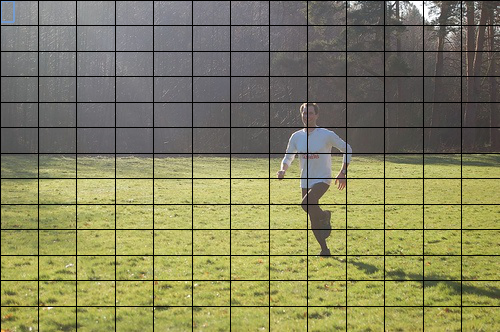

In [400]:
feed_forward(mobilenetyolov2, images[index])
index += 1

500
row: 3 col: 6 box: 0
row: 3 col: 7 box: 0
row: 3 col: 8 box: 0
row: 3 col: 9 box: 0
row: 4 col: 6 box: 0
row: 4 col: 7 box: 0
row: 4 col: 8 box: 0
row: 4 col: 9 box: 0
row: 5 col: 6 box: 0
row: 5 col: 7 box: 0
row: 5 col: 8 box: 0
row: 5 col: 9 box: 0
row: 6 col: 6 box: 0
row: 6 col: 7 box: 0
row: 6 col: 8 box: 0
row: 6 col: 9 box: 0
row: 7 col: 6 box: 0
row: 7 col: 7 box: 0
row: 7 col: 8 box: 0
row: 7 col: 9 box: 0
row: 8 col: 7 box: 0
row: 8 col: 8 box: 0
row: 8 col: 9 box: 0
row: 9 col: 7 box: 0
row: 9 col: 8 box: 0
row: 9 col: 9 box: 0
unnamed (0.8418962992015863) (229.8076923076923, 68.31538461538462) (270.1923076923077, 110.45384615384617)
unnamed (0.9424905189340085) (268.2692307692307, 68.31538461538462) (308.65384615384613, 110.45384615384617)
unnamed (0.7831459928340053) (306.7307692307692, 68.31538461538462) (347.11538461538464, 110.45384615384617)
unnamed (0.7351085528671614) (345.1923076923077, 68.31538461538462) (385.5769230769231, 110.45384615384617)
unnamed (0.99577

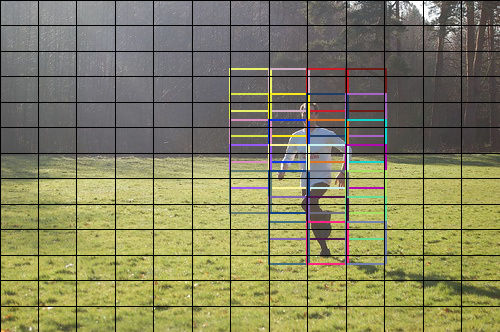

In [427]:
index = 52
runningman = images[52]
'''
encoded = encode_y_true_from_annotatoin(annotations[index])
for row in range(grid_width):
    for col in range(grid_height):
        for box in range(boxes):
            if encoded[row, col, box, 0]== 1:
                print(f'{row} {col} {box}')
'''

feed_forward(mobilenetyolov2, runningman)

In [337]:
mobilenetyolov2.save_weights('./weights/mobilenetyolov2try01')

In [ ]:
'''
things to consider:
Lambda layer which decodes output
'''